# How to think about treating heterogeneous initial populations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import sys
import pickle
from pyDOE import *
from scipy.stats.distributions import norm

In [2]:
u_N = .02
u_SCM = .005
u_TM = 0.32
u_CM = 0.35
u_EM = 0.30
u_EMRA = 0.005
std = 0.1
u_T = [u_N, u_SCM, u_TM, u_CM, u_EM,u_EMRA]

In [3]:
# Set plotting parameters
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

## Define Model

In [4]:
#Define the model
def model(z,t):
    L_n = z[0]
    L_scm = z[2]
    L_tm = z[4]
    L_cm = z[6] 
    L_em = z[8]
    L_emra = z[10]
    
    A_n = z[1]
    A_scm = z[3]
    A_tm = z[5]
    A_cm = z[7]
    A_em = z[9]
    A_emra = z[11]
    
    
    #for drug dosings
    dL_ndt = (p_n - d_n)*L_n - a*L_n + w*A_n
    dA_ndt = a*L_n - d_ALL*A_n - w*A_n
    
    dL_scmdt = (p_scm - d_scm)*L_scm - a*L_scm + w*A_scm
    dA_scmdt = a*L_scm - d_ALL*A_scm - w*A_scm
    
    dL_tmdt = (p_tm - d_tm)*L_tm - a*L_tm + w*A_tm
    dA_tmdt = a*L_tm - d_ALL*A_tm - w*A_tm
    
    dL_cmdt = (p_cm - d_cm)*L_cm - a*L_cm + w*A_cm
    dA_cmdt = a*L_cm - d_ALL*A_cm - w*A_cm
    
    dL_emdt = (p_em - d_em)*L_em - a*L_em + w*A_em
    dA_emdt = a*L_em - d_ALL*A_em - w*A_em
    
    dL_emradt = (p_emra - d_emra)*L_emra - a*L_emra + w*A_emra
    dA_emradt = a*L_emra - d_ALL*A_emra - w*A_emra
    
    
    dzdt = [dL_ndt,dA_ndt,
            dL_scmdt,dA_scmdt,
            dL_tmdt,dA_tmdt,
            dL_cmdt,dA_cmdt,
            dL_emdt,dA_emdt,
            dL_emradt,dA_emradt
            ]
    return dzdt

In [16]:
d_tmp = (lhs(1, samples=2000)*5).flatten()
parameter_arr = d_tmp
parameter_letter = 'd'


#number of time points
tn = 2000

#store solutions
L_n = np.zeros([parameter_arr.shape[0],tn])
L_scm = np.zeros([parameter_arr.shape[0],tn])
L_tm = np.zeros([parameter_arr.shape[0],tn])
L_cm = np.zeros([parameter_arr.shape[0],tn])
L_em = np.zeros([parameter_arr.shape[0],tn])
L_emra = np.zeros([parameter_arr.shape[0],tn])

A_n = np.zeros([parameter_arr.shape[0],tn])
A_scm = np.zeros([parameter_arr.shape[0],tn])
A_tm = np.zeros([parameter_arr.shape[0],tn])
A_cm = np.zeros([parameter_arr.shape[0],tn])
A_em = np.zeros([parameter_arr.shape[0],tn])
A_emra = np.zeros([parameter_arr.shape[0],tn])
Total = np.zeros([parameter_arr.shape[0],tn])





for i,parameter in enumerate(parameter_arr):
#initial conditions, there are three
    w = 1/20 # In Ke's 2015 paper, it looks like a reasonable assumption is 20-50 days because thats where copies of vRNA start dropping
    d = 1
    LRA = 1
    d_ALL = 0.003

    if parameter_letter == 'w':
        w = parameter
    elif parameter_letter == 'd_ALL':
        d_ALL = parameter
    elif parameter_letter == 'd':
        d = parameter
    elif parameter_letter == 'LRA':
        LRA = parameter
    else: 
        break
    #set parameters

    p_cm = 0.00075 * d
    p_tm = 0.0006 * d
    p_em = 0.0003 * d
    p_n = 0.000099 * d
    p_scm = 0.00001 * d
    p_emra = 0.00005 * d


    corr_fact = -np.log(1/2)
    d_n = corr_fact * (1/1500)
    d_scm = corr_fact * (1/150)
    d_tm = corr_fact * (1/100)
    d_cm = corr_fact * (1/120)
    d_em = corr_fact * (1/90)
    d_emra = corr_fact * (1/250)
    n = 0.00017
    a = n * LRA

    
    z0 = np.zeros(12)
    ctr=0
    for g in range(6):
        z0[ctr] = u_T[g]*10**6
        ctr+=2

    #time points
    b = 2000
    tn = 60001
    t = np.linspace(0,tn-1, b)


    #record intial

    L_n[i][0] = z0[0]
    L_scm[i][0] = z0[2]
    L_tm[i][0] = z0[4]
    L_cm[i][0] = z0[6] 
    L_em[i][0] = z0[8]
    L_emra[i][0] =z0[10]

    A_n[i][0] = z0[1]
    A_scm[i][0] = z0[3]
    A_tm[i][0] = z0[5]
    A_cm[i][0] = z0[7]
    A_em[i][0] = z0[9]
    A_emra[i][0] = z0[11]

    Total[i][0] = np.sum(z0)

    #Solve the ODE
    for k in range(1,b):
        tspan = [t[k-1],t[k]]
        # solve for next step
        z = odeint(model,z0,tspan)
        # store solution for plotting

        L_n[i][k] = z[1][0]
        L_scm[i][k] = z[1][2]
        L_tm[i][k] = z[1][4]
        L_cm[i][k] = z[1][6] 
        L_em[i][k] = z[1][8]
        L_emra[i][k] = z[1][10]

        A_n[i][k] = z[1][1]
        A_scm[i][k] = z[1][3]
        A_tm[i][k] = z[1][5]
        A_cm[i][k] = z[1][7]
        A_em[i][k] = z[1][9]
        A_emra[i][k] = z[1][11]


        Total[i][k] =np.sum(z[1])
        z0 = z[1] 
    sys.stdout.write('\r {}'.format(i) )

t = t/365
pop_dict = {}
pop_dict['latent'] = [L_n, L_scm, L_tm, L_cm, L_em, L_emra]
pop_dict['active'] = [A_n, A_scm, A_tm, A_cm, A_em, A_emra]
pop_dict['times'] = t
pop_dict['total'] = Total
pop_dict['cell_type'] = ['T_n', 'T_scm', 'T_tm', 'T_cm','T_em', 'T_emra']



 1999

In [17]:
pop_dict['d'] = parameter_arr

In [18]:
pickle.dump(pop_dict,open('190430_d_sensitivity.p', 'wb'))

In [36]:
y = pop_dict['total'][np.argsort(parameter_arr)]
x  = sorted(parameter_arr)


In [46]:
hill_cure = []
for i in range(2000): 
    a = np.where(y[i] <10**2)[0]
    if len(a) == 0:
        hill_cure.append(0)
    else:
        hill_cure.append(t[a[0]])
y = hill_cure

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

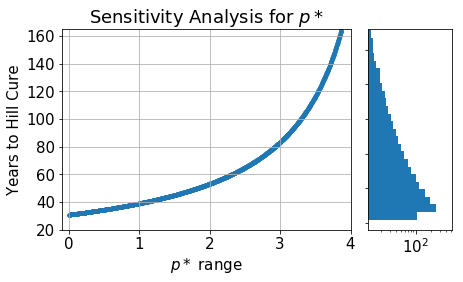

In [76]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize = (7,5))

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])
plt.grid(True)
plt.xticks(np.arange(0, 5, 1))
plt.yticks(np.arange(20,170,20))
plt.xlim([-.1,4])
plt.ylim([20,165])
ax_joint.set_xlabel(r'$p*$ range')
ax_joint.set_ylabel('Years to Hill Cure')
plt.title(r'Sensitivity Analysis for $p*$')

ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.scatter(x,y, s = 10)


ax_marg_y.hist(y,orientation="horizontal", log = True,bins = 30)

plt.ylim([20,165])
plt.setp(ax_marg_y.get_yticklabels(), visible=False)




